This was the first project I did. I wanted to detect topic trends in the papers.
The basic idea behind it was to use linear regression: A linear regression gets points from a graph and tries to fit a linear graph through the points to have a minimal distance for each point to the graph. I would use a time series and see from the fitted graph if there was a positive gradient for it which would indicate an increased interest in that word over time.
I did that in two different time frames: 1 week and 1 year
And I used two different methods: Getting the data from an RSS feed and getting the data from the constructed dataframe.

Of course I need to import all needed packages: A feedparser, Pandas, Numpy (for the linear regression), matplotlib (for graphs) and NLTK packages for linguistic pre-processing.

In [0]:
import feedparser
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag, word_tokenize
matplotlib.style.use('ggplot')
%matplotlib inline

This part is for getting the RSS feed for one day.
As some pre-work I had to figure out if the feed is updated continuously or once a day. I found that it is updated once a day, Monday to Friday. So it was sufficient to query the feed on a set time once a day.
In this example I am retrieving the Computer Science feed that looks like this:
http://export.arxiv.org/rss/cs

The feedparser gets it in a nice format already, so I am creating a list of words contained in the summaries in this case.

In [0]:
d = feedparser.parse('http://export.arxiv.org/rss/cs')
print len(d['entries'])
summary=[]
for n in range(len(d['entries'])):
    summary+=d['entries'][n]['summary'].split()

247


This code is for some linguistic pre-processing.
At first I get rid of all unwanted data like HTML tags, brackets, colons etc., normalize everything to lowercase and remove empty words.
Then I tokenize the words so that occurences of "runs" and "running" both count as occurences of "run" for example.
After that step I want to remove all "stop words". Stop words are those words in a corpus that don't give you any kind of insight (like "the", "a" etc)
I am working with different sets of stop words to get rid of as much as possible. I found this file "atire_puurula" on the internet which contained about 900 stop words in contrast to the ready NLTK set which had like 200. So I decided to also use that.
Then I run the list of words I have against those stop word lists, if the word is in neither of those lists I keep it.

In [0]:
from stop_words import get_stop_words
from nltk.corpus import stopwords
liste=summary
liste= [w.replace('<p>', '') for w in liste]
liste = [w.replace('</p>', '') for w in liste]
liste = [w.replace('.', '') for w in liste]
liste = [w.replace(',', '') for w in liste]
liste = [w.replace(':', '') for w in liste]
liste = [w.replace('!', '') for w in liste]
liste = [w.replace('(', '') for w in liste]
liste = [w.replace(')', '') for w in liste]
liste = [w.replace('"', '') for w in liste]
liste = [w.replace('$', '') for w in liste]
liste = [w.replace('{', '') for w in liste]
liste = [w.replace('}', '') for w in liste]
liste = [w.replace('[', '') for w in liste]
liste = [w.replace(']', '') for w in liste]
liste = [w.replace(w,w.lower()) for w in liste]
liste = [w.replace('\r\r\r\r\r\r\n','') for w in liste]
liste = [w.replace('\r\r\r\r\n','') for w in liste]
liste = [w.replace('\r','') for w in liste]
for element in liste:
    if element=='':
        liste.remove(element)
liste_tagged=[]
lemma=WordNetLemmatizer()
for element in liste:
    liste_tagged.append(pos_tag(word_tokenize(element)))
liste_lemma=[]
for element in liste_tagged:
    for word, tag in element:
        if tag.startswith("NN"):
            liste_lemma.append(lemma.lemmatize(word, pos='n'))
        elif tag.startswith('VB'):
            liste_lemma.append(lemma.lemmatize(word, pos='v'))
        elif tag.startswith('JJ'):
            liste_lemma.append(lemma.lemmatize(word, pos='a'))
        else:
            liste_lemma.append(word)
stop_words = get_stop_words('en')
stopWords = set(stopwords.words('english'))
fo = open("atire_puurula.txt", "r")
line = fo.readlines()
new_out=[w.replace('\n', '') for w in line]
fo.close()
liste_stopped=[]

for w in liste_lemma:
    if w not in stopWords and w not in stop_words and w not in new_out:
        liste_stopped.append(w)

For some first statistics I am counting the relative occurence of a word

In [0]:
counts = dict()
for i in liste_stopped:
  counts[i] = counts.get(i, 0) + 1
for key, value in counts.items():
    counts[key] = float(value)/float(len(liste_stopped))*100

Here I plot the outcome into a graph. You can see that the word "model" was pretty popular that day.

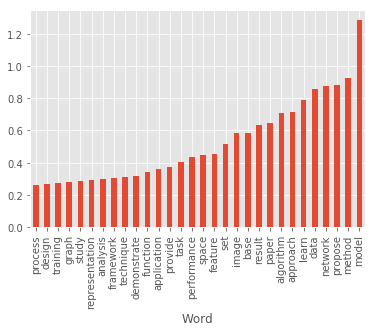

In [0]:
s = pd.Series(counts, name='Value')
s.index.name = 'Word'
s.reset_index()
s.sort_values().tail(n=30).plot(kind='bar')

Since I wanted to do this for many days I needed to store those values somewhere. I decided to fiddle around a bit with SQL a bit and created a SQLite database where I stored the word, value of relative occurence together with the date into a table.

In [0]:
date='x'
import sqlite3
db = sqlite3.connect('trends_cs_cl_summary')
cursor = db.cursor()
for key,value in counts.items():
    cursor.execute('''INSERT INTO trends(word, value, date)
                  VALUES(?,?,?)''', (key,value,date))
db.commit()
db.close()

This code is to recreate the dictionaries with the value for relative word occurences for the different days.

In [0]:
db = sqlite3.connect('trends_astro-ph_summary')
cursor = db.cursor()

cursor.execute('''SELECT word, value FROM trends WHERE date="25-06-2018"''')
dbdict1=dict()
for row in cursor:
    dbdict1.update({row[0]:row[1]})

cursor.execute('''SELECT word, value FROM trends WHERE date="26-06-2018"''')    
dbdict2=dict()
for row in cursor:
    dbdict2.update({row[0]:row[1]})

cursor.execute('''SELECT word, value FROM trends WHERE date="27-06-2018"''')
dbdict3=dict()
for row in cursor:
    dbdict3.update({row[0]:row[1]})
    
cursor.execute('''SELECT word, value FROM trends WHERE date="28-06-2018"''')
dbdict4=dict()
for row in cursor:
    dbdict4.update({row[0]:row[1]})
    
cursor.execute('''SELECT word, value FROM trends WHERE date="29-06-2018"''')
dbdict5=dict()
for row in cursor:
    dbdict5.update({row[0]:row[1]})
db.close()

Now I create a final dictionary. As a key I am using the word, as the value I store a dataframe with two columns: Column 1 has the date in a codified format (1 for the first day, 2 for the second day etc.) I am iterating over the dictionaries I created before and if I come across a new word I store the word and a new dataframe with date and relative occurence. If I come across a word that is already in the dictionary I append a row to the dataframe of that word.

In [0]:
framedict={}
for element in dbdict1.keys():
    framedict.update({element:pd.DataFrame(data={'date':[1],'value':[dbdict1[element]]})})

for element in dbdict2.keys():
    if element in framedict.keys():
        framedict.update({element:framedict.get(element).merge(pd.DataFrame(data={'date':[2],'value':[dbdict2[element]]}), how='outer')})
    else:
        framedict.update({element:pd.DataFrame(data={'date':[2],'value':[dbdict2[element]]})})
        
for element in dbdict3.keys():
    if element in framedict.keys():
        framedict.update({element:framedict.get(element).merge(pd.DataFrame(data={'date':[3],'value':[dbdict3[element]]}), how='outer')})
    else:
        framedict.update({element:pd.DataFrame(data={'date':[3],'value':[dbdict3[element]]})})

for element in dbdict4.keys():
    if element in framedict.keys():
        framedict.update({element:framedict.get(element).merge(pd.DataFrame(data={'date':[4],'value':[dbdict4[element]]}), how='outer')})
    else:
        framedict.update({element:pd.DataFrame(data={'date':[4],'value':[dbdict4[element]]})})
        
for element in dbdict5.keys():
    if element in framedict.keys():
        framedict.update({element:framedict.get(element).merge(pd.DataFrame(data={'date':[5],'value':[dbdict5[element]]}), how='outer')})
    else:
        framedict.update({element:pd.DataFrame(data={'date':[5],'value':[dbdict5[element]]})})

This code is doing the actual linear regression. It is going over each word in the dictionary and takes the dataframe. The x-axis is the time and the y axis the relative occurence of a word. After fitting the graph I look for the gradient if it passes a certain threshold (i found that threshold by experimenting which value gives me a moderate amount of outputs).
Now I can see which words had the strongest gradient. These ones are the words with the strongest positive trend.

In [0]:
for element in framedict.values():
    if element.count()[0]==1:
        continue
    else:
        lm_original = np.polyfit(element.date, element.value, 1)
        if lm_original[0]>0.05:
            for key, value in framedict.iteritems():
                if list(value.value) == list(element.value):
                    print lm_original[0],key

0.06474311738 neutrino
0.0556338344173 setup
0.0985369240861 e_c
0.0636316095462 dark
0.0584707719416 energy
0.0721853332009 gas
0.0650384816094 galaxy
0.0570356559379 eos
0.0810953239144 post-newtonian


This part is showing how it is working when you are using the dataframe as a base.

In [0]:
frame=pd.read_csv('framemai17.csv')
frame=frame.drop(frame.columns[0], axis=1)

This code generally works like explained above, it is just modified to fit for one year and not for one week.

In [0]:
import re
summary=[]
for element in frame.iterrows():
    if re.search("Astrophysics",element[1]["Subjects"]) and re.search("abs/1805",element[1]["Identifier"]):
        summary+=element[1]["Description"].split()
summary = [w.replace('<p>', '') for w in summary]
summary = [w.replace('</p>', '') for w in summary]
summary = [w.replace('.', '') for w in summary]
summary = [w.replace(',', '') for w in summary]
summary = [w.replace(':', '') for w in summary]
summary = [w.replace('!', '') for w in summary]
summary = [w.replace('(', '') for w in summary]
summary = [w.replace(')', '') for w in summary]
summary = [w.replace('"', '') for w in summary]
summary = [w.replace('$', '') for w in summary]
summary = [w.replace('{', '') for w in summary]
summary = [w.replace('}', '') for w in summary]
summary = [w.replace('[', '') for w in summary]
summary = [w.replace(']', '') for w in summary]
summary = [w.replace(w,w.lower()) for w in summary]
for element in summary:
    if element=='':
        summary.remove(element)
encoded=[]
for element in summary:
    encoded.append(element.decode("utf-8"))
summary=encoded

summary_tagged=[]
lemma=WordNetLemmatizer()
for element in summary:
    summary_tagged.append(pos_tag(word_tokenize(element)))

summary=[]
for element in summary_tagged:
    for word, tag in element:
        if tag.startswith("NN"):
            summary.append(lemma.lemmatize(word, pos='n'))
        elif tag.startswith('VB'):
            summary.append(lemma.lemmatize(word, pos='v'))
        elif tag.startswith('JJ'):
            summary.append(lemma.lemmatize(word, pos='a'))
        else:
            summary.append(word)
from stop_words import get_stop_words

stop_words = get_stop_words('en')

from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))
fo = open("atire_puurula.txt", "r")
line = fo.readlines()
new_out=[w.replace('\n', '') for w in line]
fo.close()

output=[]

for w in summary:
    if w.lower() not in stopWords and w.lower() not in stop_words and w.lower() not in new_out:
        output.append(w)


dbdict13 = dict()
for i in output:
    dbdict13[i] = dbdict13.get(i, 0) + 1
for key, value in dbdict13.items():
    dbdict13[key] = float(value)/float(len(output))*100